<a href="https://colab.research.google.com/github/1oneweeek/TIL/blob/main/entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


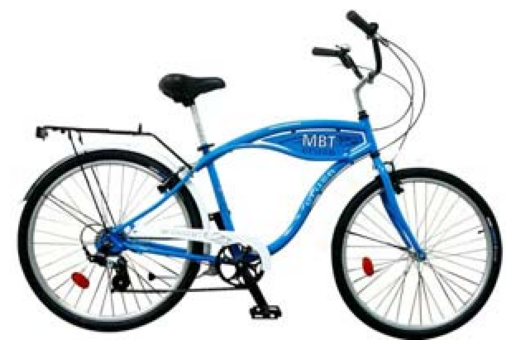

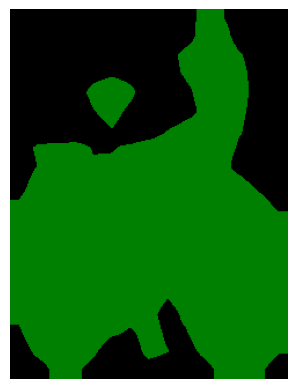

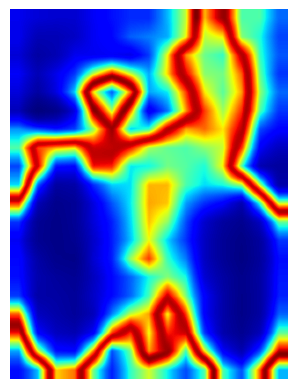

Entropy for all classes: 21608.564


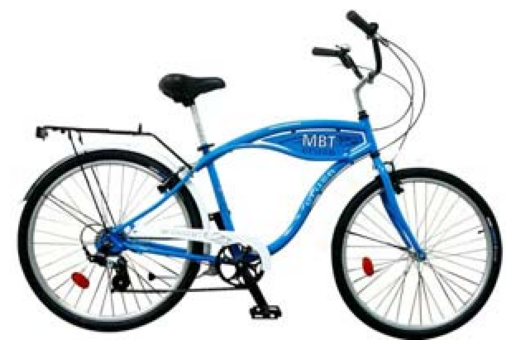

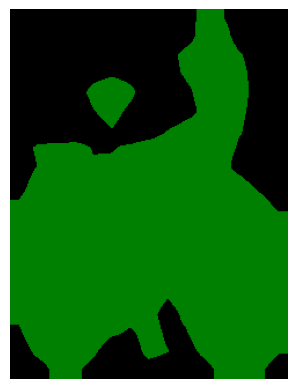

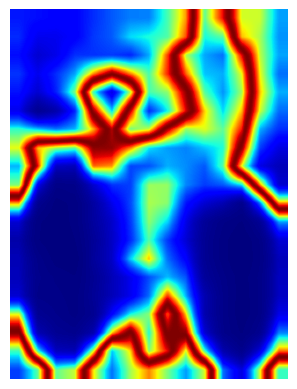

Entropy for specific classes: 9694.446


In [45]:
import torch
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Define the helper function
def decode_segmap(image, nc=21): # 세그멘테이션 맵을 받아 RGB 이미지로 디코딩
# 21: pascal voc dataset 클래스 수

    # 클래스 인덱스에 대한 RGB 색상을 정의하는 배열로 각 클래스 인덱스에 해당하는 색상을 포함
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    # image와 같은 모양의 행렬을 만들고, 모든 원소를 0으로 채워서 세그멘테이션 맵을 디코딩한 결과를 담을 빈 이미지 생성

    for l in range(0, nc): # 클래스 수에 따라 반복 루프
        idx = image == l # 현재 클래스에 해당하는 픽셀 선택
        # 선택한 픽셀에 대해 RGB 색상을 할당(현재 클래스에 해당하는 인덱스에 저장된 색)
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def segment_and_entropy(net, path, show_orig=True, classes=-1, dev='cuda'):
    img = Image.open(path)
    if show_orig:
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    # Transformation
    trf = T.Compose([T.Resize((320, 240)),
                     T.ToTensor(),
                     T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    # Apply transformation and move to device
    inp = trf(img).unsqueeze(0).to(dev) # trf로 입력 이미지를 변환하여 모델이 처리할 수 있는 형식으로 변환

    # Get output from network
    out = net.to(dev)(inp)['out'] # . net.to(dev)로 네트워크를 지정된 장치로 이동시킨 다음 입력 이미지를 모델에 전달
    # 이 모델의 출력은 주로 딕셔너리 형태. 여기서 'out' 키를 사용하여 세그멘테이션 결과를 가져옴

    # Get segmentation map
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    # .detach().cpu().numpy(): 연산 그래프에서 분리, CPU로 이동 후 numpy 배열로 변환
    # 파이토치 텐서에서 넘파이 배열로 변환하여 이미지를 처리

    # Decode segmentation map to RGB
    # 세그멘테이션 맵을 RGB 이미지로 디코딩
    # 각 클래스에 대해 정의된 색상을 사용하여 세그멘테이션 맵을 색상으로 매핑
    # : 원본 이미지와 같은 시각화된 세그멘테이션 결과를 얻도록하기위함
    rgb = decode_segmap(om)

    # Plot segmented image
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

    # Calculate entropy map
    out_soft = torch.softmax(out, dim=1)
    entropy_map = -out_soft * torch.log(out_soft + 1e-6)

    # 모든 클래스의 엔트로피를 계산하는 경우와 특정 클래스의 엔트로피를 계산하는 경우를 나눔
    if classes == -1:
        entropy_map = torch.sum(entropy_map, dim=1)
    else:
       indices = torch.tensor(classes, device=entropy_map.device)  # device 인수 추가
       entropy_map = torch.index_select(entropy_map, 1, indices) # 특정 클래스의 인덱스를 사용하여 해당 클래스에 대한 엔트로피만 선택
       entropy_map = torch.sum(entropy_map, dim=1) # 이를 합산하여 해당 클래스의 픽셀맵 얻음

    # Plot entropy map
    entropy_map_np = entropy_map.squeeze().detach().cpu().numpy()  # 차원 크기가 1인 차원을 제거하고 CPU로 옮긴 후 numpy 배열로 변환
    plt.imshow(entropy_map_np, cmap=plt.cm.jet)
    plt.axis('off')
    plt.show()

    # Calculate entropy
    entropy = np.sum(entropy_map_np)

    return entropy

# Load DeepLabV3-Mobilenet model
dlab_mobilenet = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True).eval()

# Path to the image
path = "/content/drive/MyDrive/torch_study/segmentation/images/entropy_images/test_1.jpg"

# Calculate entropy for all classes
entropy_all_classes = segment_and_entropy(dlab_mobilenet, path, classes=-1)
print("Entropy for all classes:", entropy_all_classes)

# Calculate entropy for specific classes
entropy_specific_class = segment_and_entropy(dlab_mobilenet, path, classes=2)
print("Entropy for specific classes:", entropy_specific_class)


Entropy for all classes: 21608.564


Entropy for specific classes: 9694.446

"자전거" 클래스에 대한 엔트로피가 전체 이미지에 대한 엔트로피보다 낮음: 이미지에서 자전거의 위치 또는 형태가 다른 클래스보다 더 명확하게 나타나고 있다는 것을 의미함. 모델이 자전거를 인식하는 데 더 자신감을 가지고 있거나, 이미지에서 자전거가 더 잘 구분되고 있는 것을 의미.

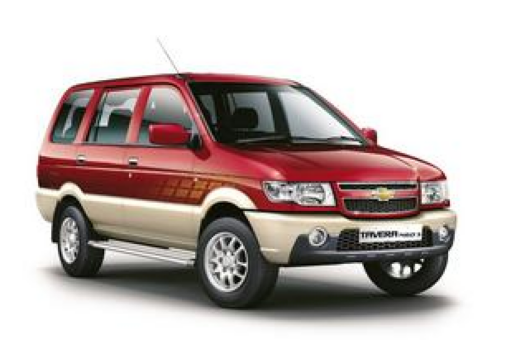

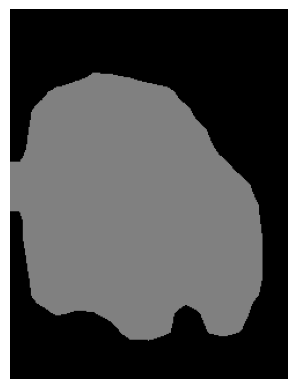

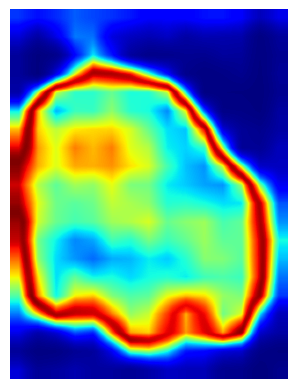

Entropy for all classes: 23597.385


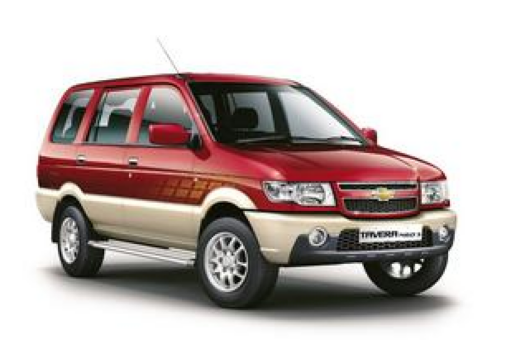

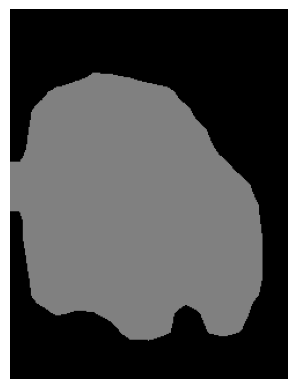

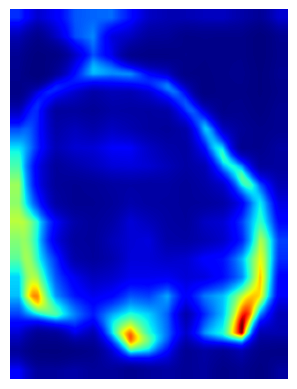

Entropy for specific classes: 53.51429


In [46]:
import torch
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Define the helper function
def decode_segmap(image, nc=21):

    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def segment_and_entropy(net, path, show_orig=True, classes=-1, dev='cuda'):
    img = Image.open(path)
    if show_orig:
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    # Transformation
    trf = T.Compose([T.Resize((320, 240)),
                     T.ToTensor(),
                     T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    # Apply transformation and move to device
    inp = trf(img).unsqueeze(0).to(dev)

    # Get output from network
    out = net.to(dev)(inp)['out']

    # Get segmentation map
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()

    # Decode segmentation map to RGB
    rgb = decode_segmap(om)

    # Plot segmented image
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

    # Calculate entropy map
    out_soft = torch.softmax(out, dim=1)
    entropy_map = -out_soft * torch.log(out_soft + 1e-6)

    if classes == -1:
        entropy_map = torch.sum(entropy_map, dim=1)
    else:
       indices = torch.tensor(classes, device=entropy_map.device)  # device 인수 추가
       entropy_map = torch.index_select(entropy_map, 1, indices)
       entropy_map = torch.sum(entropy_map, dim=1)


    # Plot entropy map
    entropy_map_np = entropy_map.squeeze().detach().cpu().numpy()  # 차원 크기가 1인 차원을 제거하고 CPU로 옮긴 후 numpy 배열로 변환
    plt.imshow(entropy_map_np, cmap=plt.cm.jet)
    plt.axis('off')
    plt.show()

    # Calculate entropy
    entropy = np.sum(entropy_map_np)

    return entropy

# Load DeepLabV3-Mobilenet model
dlab_mobilenet = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True).eval()

# Path to the image
path = "/content/drive/MyDrive/torch_study/segmentation/images/entropy_images/test_5.jpg"

# Calculate entropy for all classes
entropy_all_classes = segment_and_entropy(dlab_mobilenet, path, classes=-1)
print("Entropy for all classes:", entropy_all_classes)

# Calculate entropy for specific classes
entropy_specific_class = segment_and_entropy(dlab_mobilenet, path, classes=2)
print("Entropy for specific classes:", entropy_specific_class)
